Load importance scores. In this example, these are the importance scores for the positive examples for task 0 in the talgata simulation from the deeplift paper (analysis is done on the test set)

In [1]:
!./grab_data.sh

%matplotlib inline
import numpy as np
import h5py
multipliers = np.array(h5py.File("talgata_task0_positives_multipliers.hdf5","r")["/values"]).astype("float32")
deeplift_scores = np.array(h5py.File("talgata_task0_positives_scores.hdf5","r")["/values"]).astype("float32")
print(multipliers.shape)
print(deeplift_scores.shape)

File talgata_task0_positives_multipliers.npy exists already
File talgata_task0_positives_scores.npy exists already
(236, 200, 4)
(236, 200, 4)


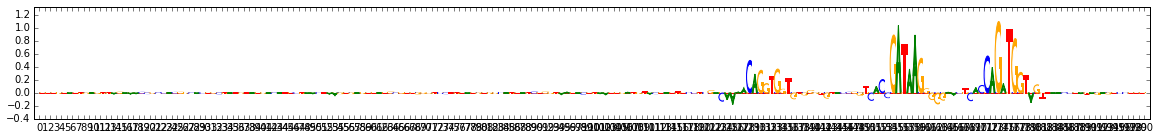

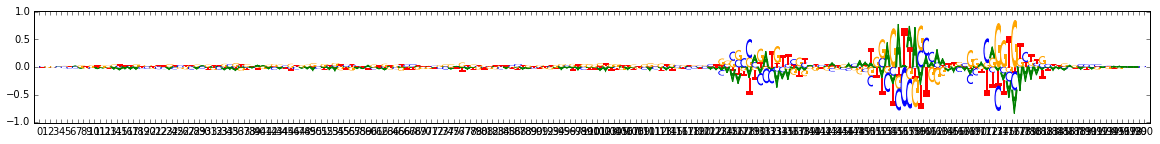

In [2]:
#concatenate with reverse complement to demonstrate that MoDISco can
#handle reverse complements
multipliers = np.concatenate([multipliers, multipliers[:,::-1,::-1]], axis=0)
deeplift_scores = np.concatenate([deeplift_scores, deeplift_scores[:,::-1,::-1]], axis=0)

#mean normalize multipliers at each position (not the theoretically best thing to do, but is nice and quick)
#theoretically best thing would be to estimate contributions for each of the 4 possible
#one-hot encodings using multipliers*[hypothetical difference-from-reference] at each position.
multipliers = multipliers-np.mean(multipliers,axis=2)[:,:,None]

#extract the one-hot encoding using the DeepLIFT track
onehot_seq = (np.abs(deeplift_scores) > 0)*1.0
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(deeplift_scores[0])
viz_sequence.plot_weights(multipliers[0])

In [3]:
from modisco import core
reload(core)
deeplift_score_track = core.DataTrack(name="deeplift_scores", fwd_tracks=deeplift_scores,
                             rev_tracks=deeplift_scores[:,::-1,::-1],
                             has_pos_axis=True)
multipliers_score_track = core.DataTrack(name="multipliers", fwd_tracks=multipliers,
                             rev_tracks=multipliers[:,::-1,::-1],
                             has_pos_axis=True)
onehot_track = core.DataTrack(name="sequence", fwd_tracks=onehot_seq,
                               rev_tracks=onehot_seq[:,::-1,::-1],
                               has_pos_axis=True)
track_set = core.TrackSet(data_tracks=[deeplift_score_track, multipliers_score_track, onehot_track])

In [15]:
from modisco import coordproducers
reload(coordproducers)
reload(core)

seqlets = track_set.create_seqlets(track_names=["deeplift_scores","multipliers", "sequence"],
                                   coords=coordproducers.FixedWindowAroundChunks(
                                            sliding=11, flank=5,
                                            suppress=10, min_ratio=0.5,
                                            max_seqlets_per_seq=6,
                                            batch_size=50, progress_update=5000,
                                            verbose=True).get_coords(np.sum(deeplift_scores, axis=2)))
print(len(seqlets))
#sort the seqlets by strength
seqlets = sorted(seqlets, key=lambda x: -np.sum(x["deeplift_scores"].fwd))

Compiling functions
Computing window sums
('Done', 0)
Identifying seqlet coordinates
('Done', 0)
('Done', 0)
('Done', 0)
('Done', 0)
('Done', 0)
('Done', 0)
1003


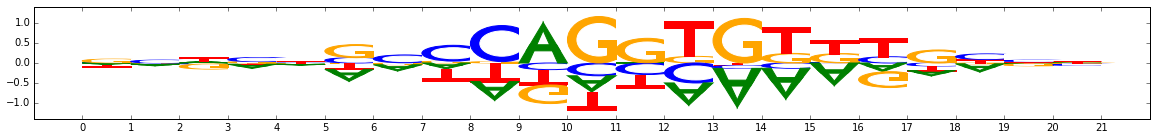

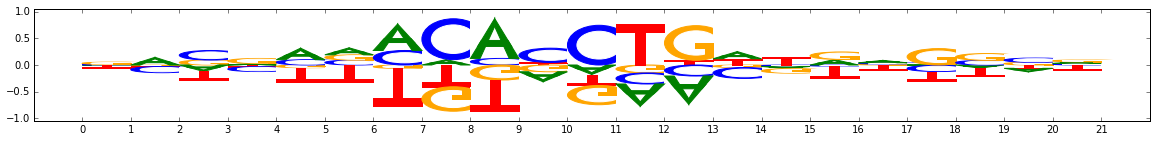

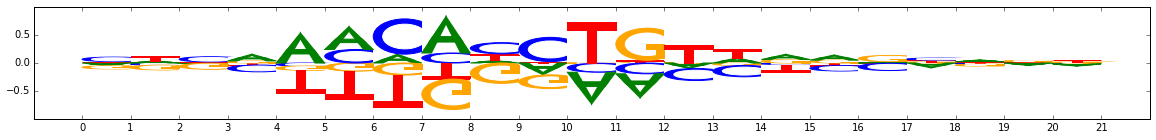

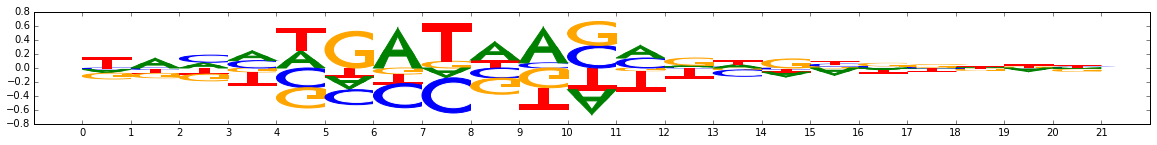

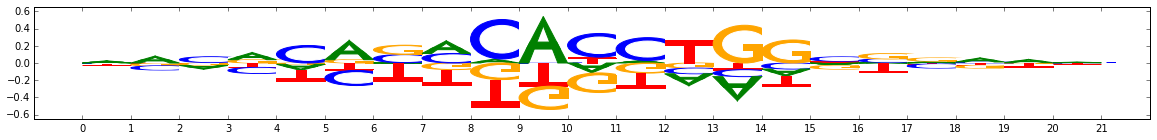

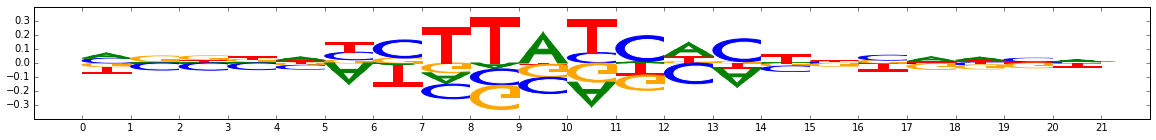

In [5]:
#print 5 seqlets drawn from across the range, as a sanity check
for i in range(0,len(seqlets),int(len(seqlets)/5)):
    viz_sequence.plot_weights(seqlets[i]["multipliers"].fwd)

In [6]:
from modisco import affinitymat as affmat
pattern_crosscorr_settings = affmat.PatternCrossCorrSettings(
                    track_names=["multipliers"],                                     
                    normalizer=affmat.MeanNormalizer().chain(affmat.MagnitudeNormalizer()),   
                    min_overlap=0.3)
affinity_mat_from_seqlets = affmat.MaxCrossCorrAffinityMatrixFromSeqlets(pattern_crosscorr_settings=pattern_crosscorr_settings)
affinity_mat = affinity_mat_from_seqlets(seqlets)

('On filters', 0, 'to', 11904)
('Done', 0)
('Done', 1000)
('On filters', 0, 'to', 11904)
('Done', 0)
('Done', 1000)


In [7]:
from modisco.cluster import core as mclust
ks_to_try = [30, 100, 200, 400]
k_to_num_clusters = {}
for k in ks_to_try:
    cluster_results = mclust.PhenographCluster(k=k).cluster(affinity_mat=affinity_mat)
    k_to_num_clusters[k] = max(cluster_results.cluster_indices)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.253621101379 seconds
Jaccard graph constructed in 0.147437095642 seconds
Wrote graph to binary file in 0.0210041999817 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.896315
Louvain completed 21 runs in 0.383970022202 seconds
PhenoGraph complete in 0.8182721138 seconds
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.229384899139 seconds
Jaccard graph constructed in 0.728057861328 seconds
Wrote graph to binary file in 0.0931510925293 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.78398
Louvain completed 21 runs in 0.505883932114 seconds
PhenoGraph complete in 1.57257080078 seconds
Finding 200 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.38093495369 seconds
Jaccard graph constructed in 2.30867695808 seconds
Wrote graph 

In [8]:
for k in ks_to_try:
    print("k: "+str(k)+" num_clusters: "+str(k_to_num_clusters[k]+1))

k: 30 num_clusters: 12
k: 100 num_clusters: 8
k: 200 num_clusters: 4
k: 400 num_clusters: 2


No colors supplied, so autogen'd as:
(0, (0, 1.0, 0.0))
(1, (0.5, 0, 0.5))


/Users/avantishrikumar/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


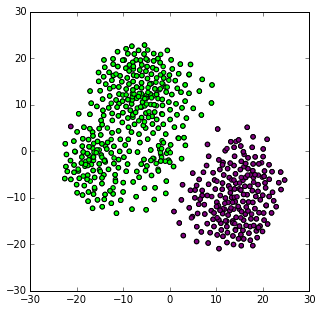

In [9]:
from modisco.visualization import tsne
reload(tsne)
import modisco
reload(modisco.visualization.matplotlibhelpers)

embedding = tsne.get_tsne_embedding(affinity_mat=affinity_mat, perplexity=50)
tsne.color_tsne_embedding_by_clustering(embedding=embedding, clusters=cluster_results.cluster_indices)

In [17]:
from collections import defaultdict
cluster_to_seqlets = defaultdict(list)
for cluster_val, seqlet in zip(cluster_results.cluster_indices, seqlets):
    cluster_to_seqlets[cluster_val].append(seqlet)

In [21]:
from modisco import aggregator
reload(aggregator)
reload(core)

num_clusters = max(cluster_results.cluster_indices)+1

pattern_aligner = core.CrossCorrelationPatternAligner(
                        pattern_crosscorr_settings=pattern_crosscorr_settings)
seqlet_aggregator = aggregator.HierarchicalSeqletAggregator(pattern_aligner=pattern_aligner,
                                                            affinity_mat_from_seqlets=affinity_mat_from_seqlets)
cluster_to_aggregated_seqlets = {}
for i in range(num_clusters):
    cluster_to_aggregated_seqlets[i] = seqlet_aggregator(cluster_to_seqlets[i])

('On filters', 0, 'to', 11904)
('Done', 0)
('On filters', 0, 'to', 11904)
('Done', 0)
('On filters', 0, 'to', 11904)
('Done', 0)
('On filters', 0, 'to', 11904)
('Done', 0)


Cluster 0:
fwd:


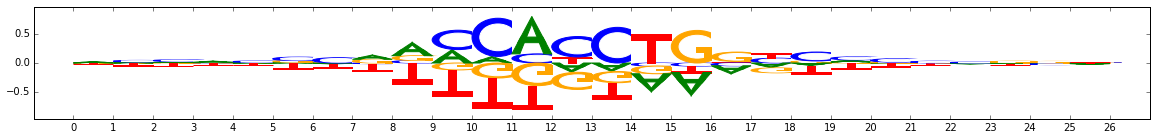

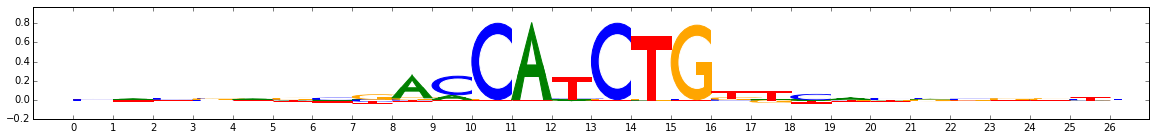

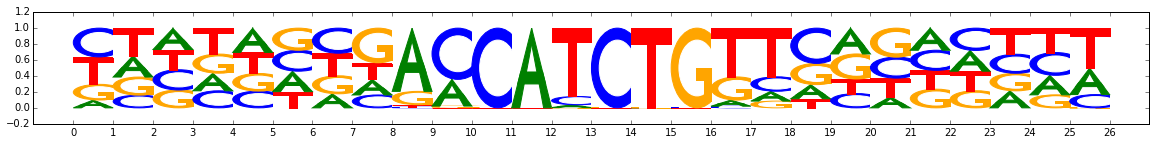

reverse:


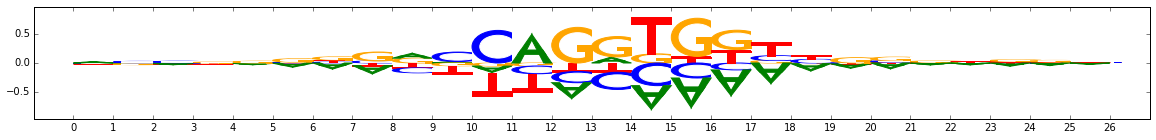

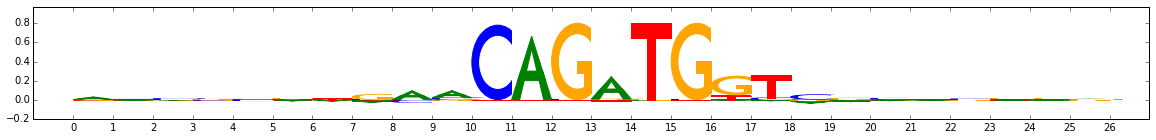

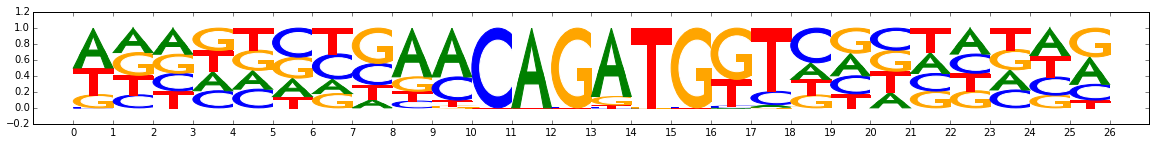

Individual seqlets and their alignments:
('alignment:', 3)


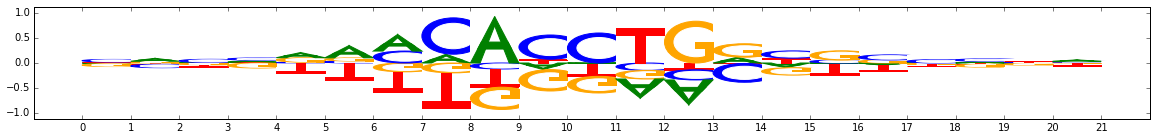

('alignment:', 3)


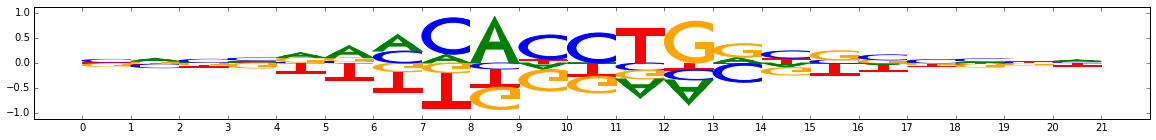

('alignment:', 2)


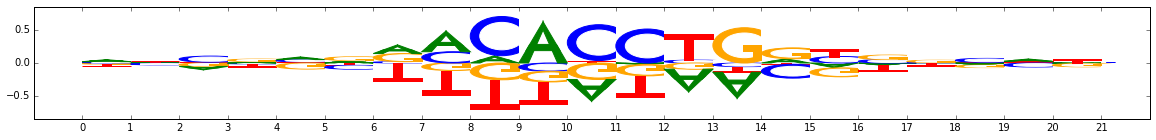

('alignment:', 2)


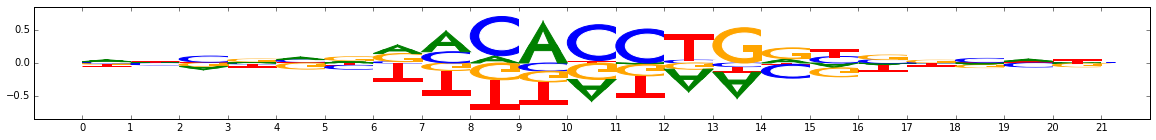

('alignment:', 3)


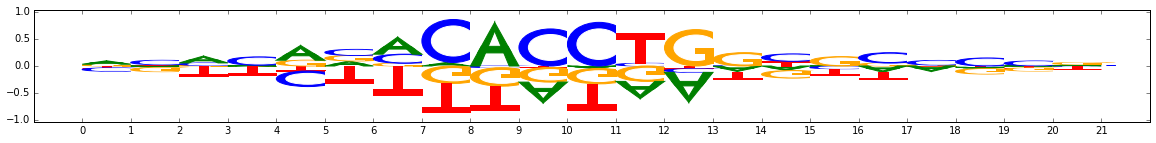

Cluster 1:
fwd:


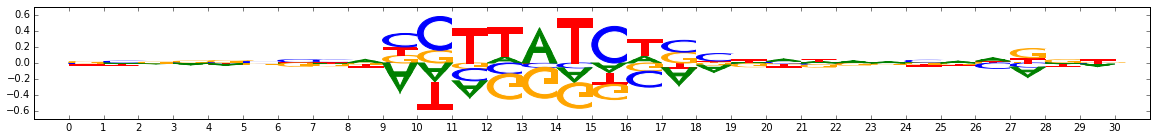

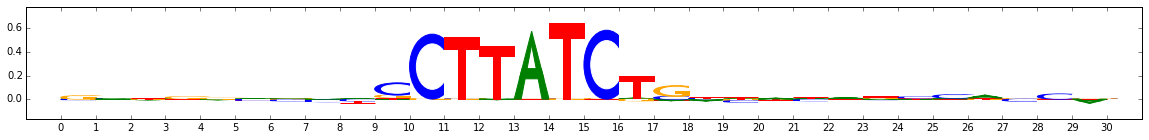

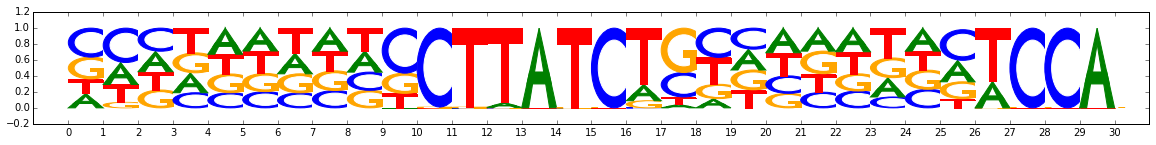

reverse:


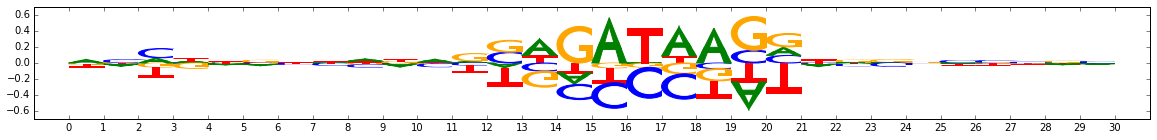

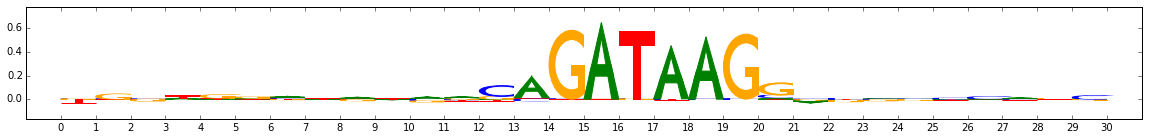

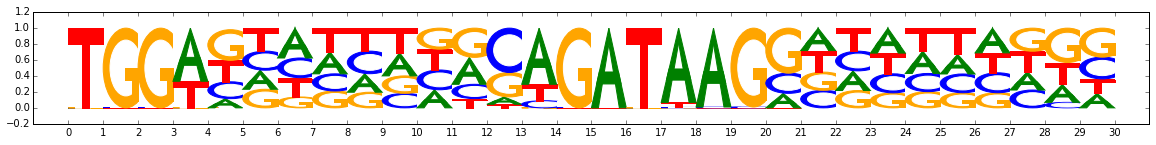

Individual seqlets and their alignments:
('alignment:', 3)


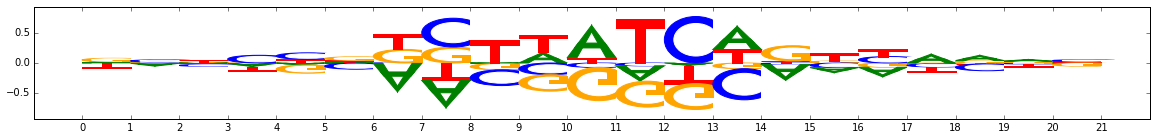

('alignment:', 3)


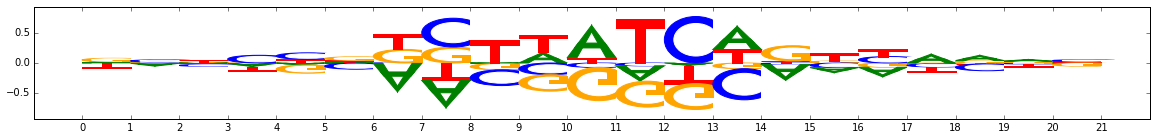

('alignment:', 3)


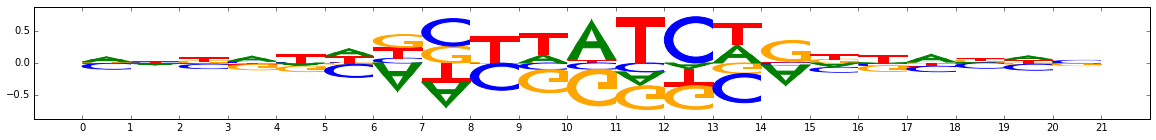

('alignment:', 4)


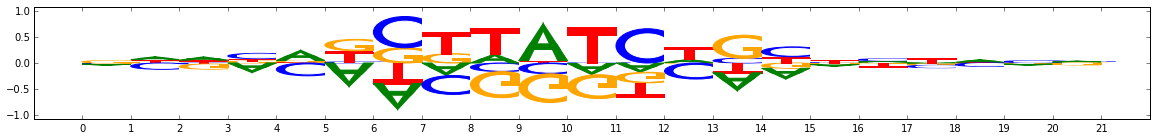

('alignment:', 4)


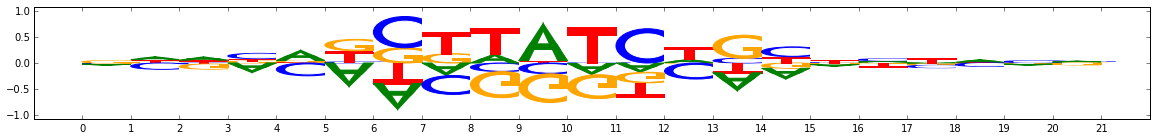

In [24]:
for i in range(num_clusters):
    print("Cluster "+str(i)+":")
    #currently, aggregated_seqlets always has length 1 but leaving it flexible
    #so aggregator could return several motifs in the future
    for aggregated_seqlet in cluster_to_aggregated_seqlets[i]:
        print("fwd:")
        viz_sequence.plot_weights(aggregated_seqlet["multipliers"].fwd)
        viz_sequence.plot_weights(aggregated_seqlet["deeplift_scores"].fwd)
        viz_sequence.plot_weights(aggregated_seqlet["sequence"].fwd)
        print("reverse:")
        viz_sequence.plot_weights(aggregated_seqlet["multipliers"].rev)
        viz_sequence.plot_weights(aggregated_seqlet["deeplift_scores"].rev)
        viz_sequence.plot_weights(aggregated_seqlet["sequence"].rev)
        
        print("Individual seqlets and their alignments:")
        #view individual seqlets under the aggregated seqlet
        for seqlet_and_alnmt in aggregated_seqlet.seqlets_and_alnmts[:5]:
            print("alignment:",seqlet_and_alnmt.alnmt)
            viz_sequence.plot_weights(seqlet_and_alnmt.seqlet["multipliers"].fwd)